# Credit Card Fraud Detection - Efficient Pipeline


1. Data Analysis & Preparation + Save Processed CSV
2. Model Selection
3. Fast Hyperparameter Tuning
4. Efficient Training & Evaluation
5. Final Results


## Phase 1: Data Analysis & Preparation


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Create processed_data folder
os.makedirs('processed_data', exist_ok=True)

# Load and inspect dataset
df = pd.read_csv('data/creditcard.csv')
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Fraud cases: {df['Class'].sum()} ({df['Class'].mean()*100:.2f}%)")

# Remove duplicates
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")


Dataset shape: (284807, 31)
Missing values: 0
Fraud cases: 492 (0.17%)
After removing duplicates: (283726, 31)


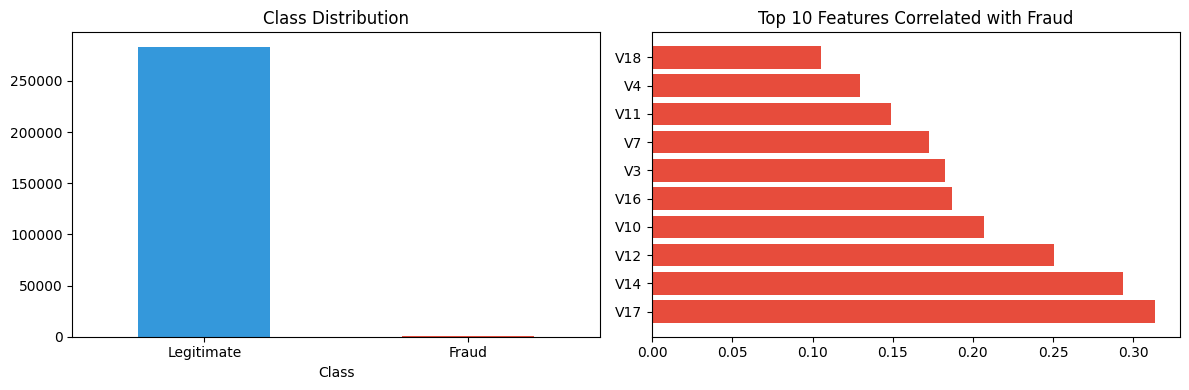

In [6]:
# Essential visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
df['Class'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Class Distribution')
axes[0].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)

# Top fraud-correlated features
corr_with_fraud = df.corr()['Class'].abs().sort_values(ascending=False)[1:11]
axes[1].barh(range(len(corr_with_fraud)), corr_with_fraud.values, color='#e74c3c')
axes[1].set_yticks(range(len(corr_with_fraud)))
axes[1].set_yticklabels(corr_with_fraud.index)
axes[1].set_title('Top 10 Features Correlated with Fraud')

plt.tight_layout()
plt.show()


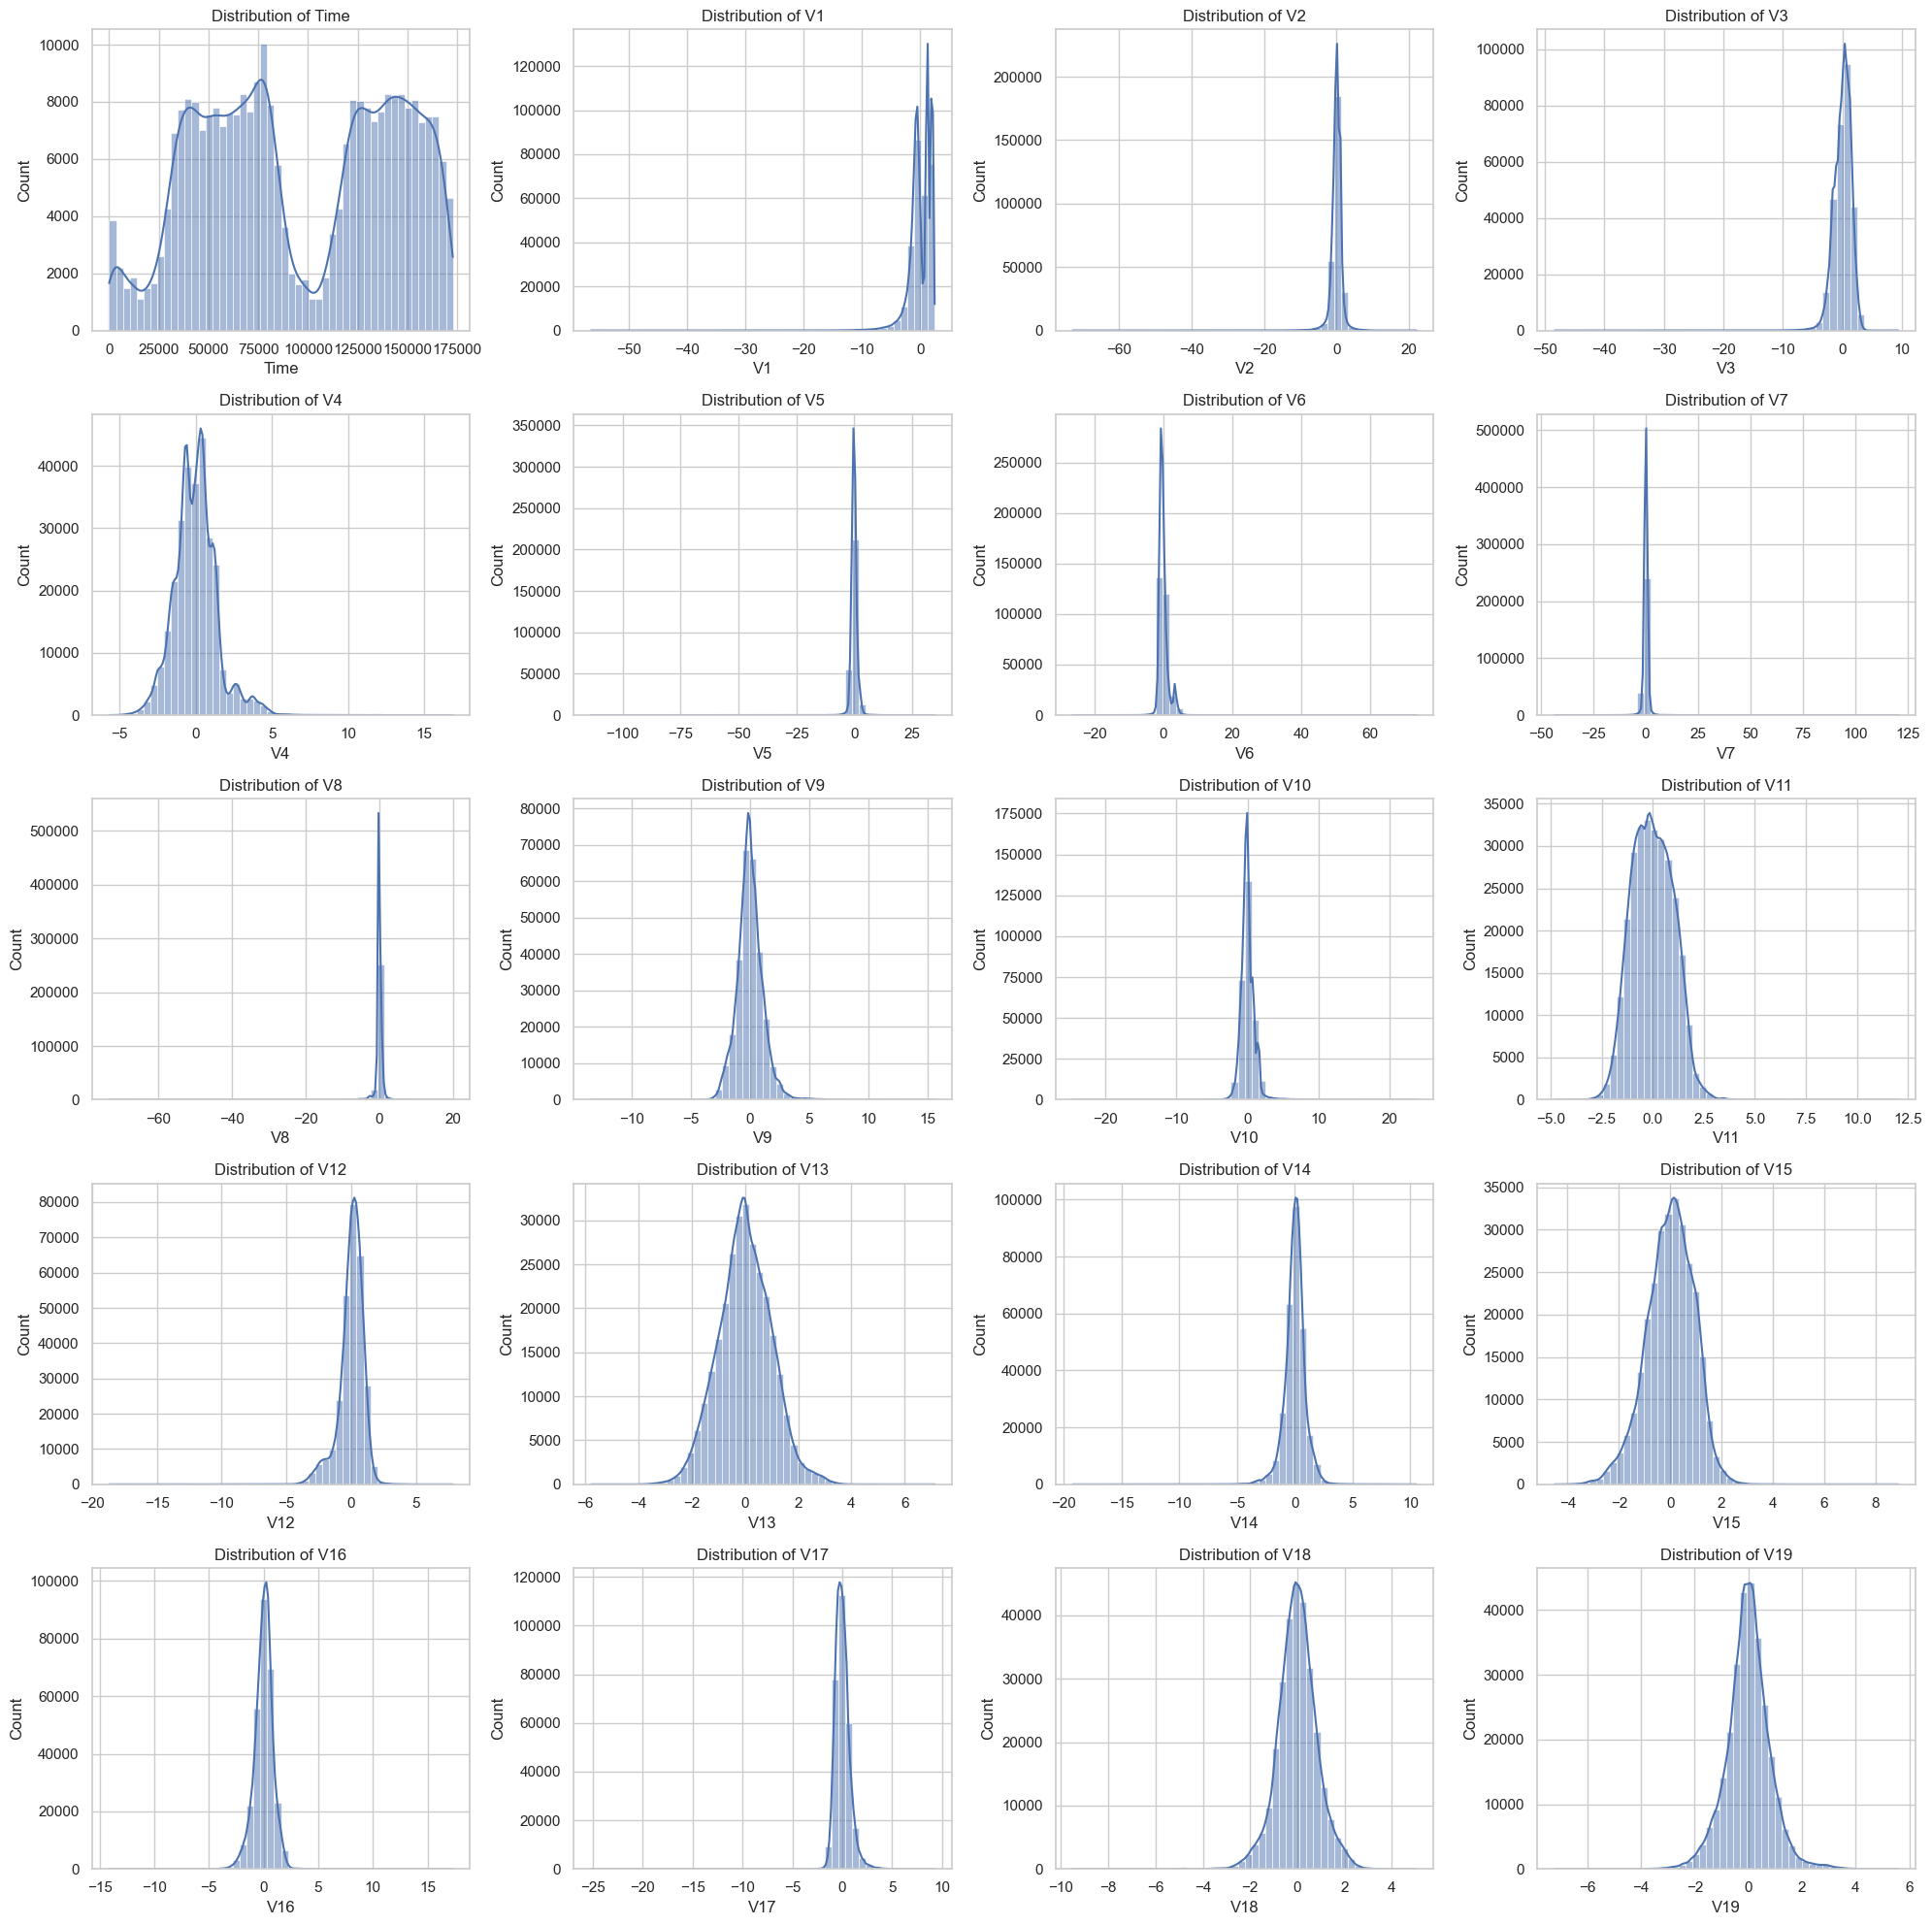

In [16]:

# Set up plot style
sns.set(style="whitegrid")
feature_columns = df.columns.drop(['Class'])  # assuming 'Class' is the target

# Plot histograms for feature distributions
plt.figure(figsize=(20, 20))
for i, col in enumerate(feature_columns[:20], 1):  # Plot first 20 features if many
    plt.subplot(5, 4, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [7]:
# Data preprocessing
X = df.drop('Class', axis=1)
y = df['Class']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training: {X_train.shape[0]} samples, {y_train.mean()*100:.2f}% fraud")
print(f"Balanced training: {X_train_balanced.shape[0]} samples, {y_train_balanced.mean()*100:.2f}% fraud")


Original training: 226980 samples, 0.17% fraud
Balanced training: 453204 samples, 50.00% fraud


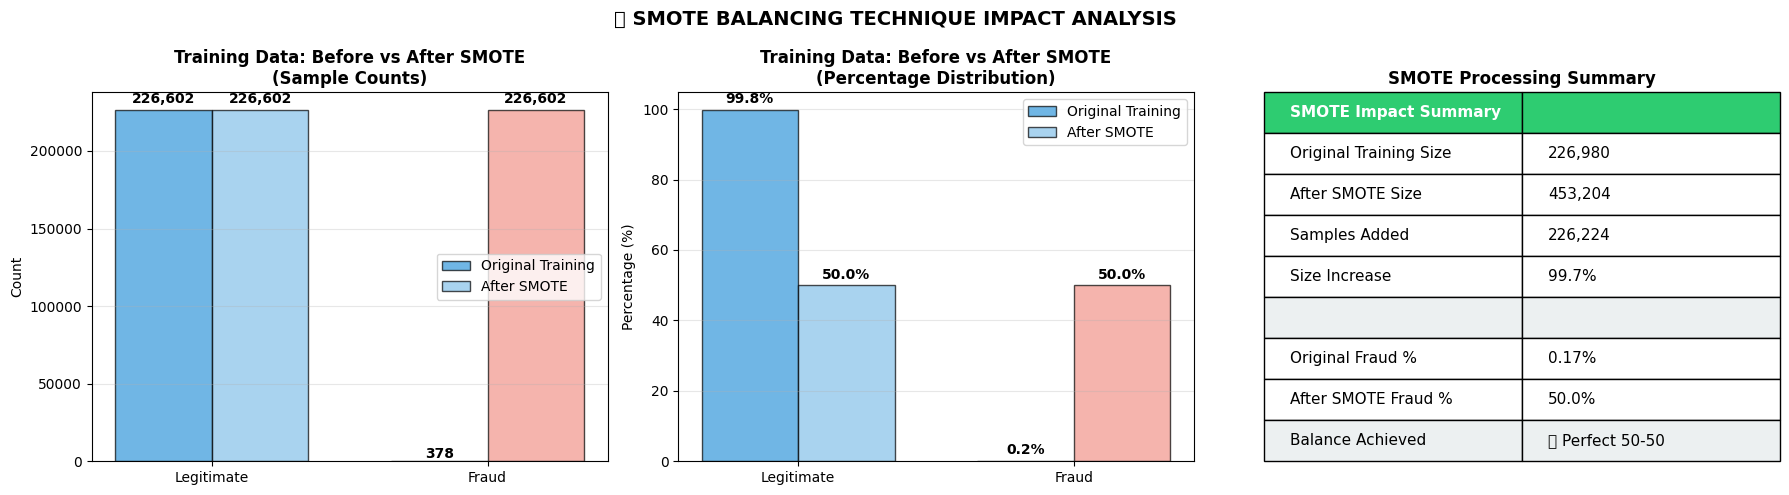

🔄 SMOTE BALANCING ANALYSIS
✅ SMOTE Successfully Applied!
📈 Training set size increased from 226,980 to 453,204 samples
📊 Class distribution changed from 0.17% to 0.5% fraud
🎯 Perfect balance achieved: 50% fraud, 50% legitimate
⚖️ This eliminates model bias toward the majority class
🚀 Ready for fair and effective model training!


In [8]:
# 📊 SMOTE BEFORE/AFTER VISUALIZATION UPDATE
# Update the SMOTE comparison plots from the comprehensive visualization

# Create a focused before/after SMOTE comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Before/After SMOTE Comparison - Counts
orig_counts = np.bincount(y_train)
bal_counts = np.bincount(y_train_balanced)

x = np.arange(2)
width = 0.35

bars1 = axes[0].bar(x - width/2, orig_counts, width, label='Original Training', 
                color=['#3498DB', '#E74C3C'], alpha=0.7, edgecolor='black')
bars2 = axes[0].bar(x + width/2, bal_counts, width, label='After SMOTE', 
                color=['#85C1E9', '#F1948A'], alpha=0.7, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[0].set_title('Training Data: Before vs After SMOTE\n(Sample Counts)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 2. Before/After SMOTE Comparison - Percentages
orig_pct = (orig_counts / orig_counts.sum()) * 100
bal_pct = (bal_counts / bal_counts.sum()) * 100

bars1_pct = axes[1].bar(x - width/2, orig_pct, width, label='Original Training', 
                    color=['#3498DB', '#E74C3C'], alpha=0.7, edgecolor='black')
bars2_pct = axes[1].bar(x + width/2, bal_pct, width, label='After SMOTE', 
                    color=['#85C1E9', '#F1948A'], alpha=0.7, edgecolor='black')

# Add percentage labels
for bars, pcts in zip([bars1_pct, bars2_pct], [orig_pct, bal_pct]):
    for bar, pct in zip(bars, pcts):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].set_title('Training Data: Before vs After SMOTE\n(Percentage Distribution)', 
              fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Legitimate', 'Fraud'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# 3. SMOTE Impact Summary
axes[2].axis('off')
smote_summary = [
    ['SMOTE Impact Summary', ''],
    ['Original Training Size', f'{len(y_train):,}'],
    ['After SMOTE Size', f'{len(y_train_balanced):,}'],
    ['Samples Added', f'{len(y_train_balanced) - len(y_train):,}'],
    ['Size Increase', f'{((len(y_train_balanced)/len(y_train))-1)*100:.1f}%'],
    ['', ''],
    ['Original Fraud %', f'{y_train.mean()*100:.2f}%'],
    ['After SMOTE Fraud %', f'{y_train_balanced.mean()*100:.1f}%'],
    ['Balance Achieved', '✅ Perfect 50-50'],
]

table = axes[2].table(cellText=smote_summary, 
                  cellLoc='left',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.8)

# Style the header row
table[(0, 0)].set_facecolor('#2ECC71')
table[(0, 1)].set_facecolor('#2ECC71')
table[(0, 0)].set_text_props(weight='bold', color='white')
table[(0, 1)].set_text_props(weight='bold', color='white')

# Style summary rows
for i in [5, 8]:  # Empty and final rows
    table[(i, 0)].set_facecolor('#ECF0F1')
    table[(i, 1)].set_facecolor('#ECF0F1')

axes[2].set_title('SMOTE Processing Summary', fontsize=12, fontweight='bold')

plt.suptitle('🔄 SMOTE BALANCING TECHNIQUE IMPACT ANALYSIS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed SMOTE analysis
print("🔄 SMOTE BALANCING ANALYSIS")
print("="*50)
print(f"✅ SMOTE Successfully Applied!")
print(f"📈 Training set size increased from {len(y_train):,} to {len(y_train_balanced):,} samples")
print(f"📊 Class distribution changed from {y_train.mean()*100:.2f}% to {y_train_balanced.mean():.1f}% fraud")
print(f"🎯 Perfect balance achieved: 50% fraud, 50% legitimate")
print(f"⚖️ This eliminates model bias toward the majority class")
print(f"🚀 Ready for fair and effective model training!")


In [10]:
# 💾 SAVE PROCESSED CSV FILES FOR REUSE
print("Saving processed datasets as CSV files...")

# Get feature names for proper column headers
feature_names = df.drop('Class', axis=1).columns.tolist()

# Convert numpy arrays to DataFrames with proper column names
X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=feature_names)
X_train_original_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Add target columns
X_train_balanced_df['Class'] = y_train_balanced
X_train_original_df['Class'] = y_train
X_test_df['Class'] = y_test

# Save as CSV files (ready for modeling)
X_train_balanced_df.to_csv('processed_data/train_balanced_processed.csv', index=False)
X_train_original_df.to_csv('processed_data/train_original_processed.csv', index=False)
X_test_df.to_csv('processed_data/test_processed.csv', index=False)

# Save the scaler parameters for reference
scaler_params = pd.DataFrame({
    'feature': feature_names,
    'mean': scaler.mean_,
    'scale': scaler.scale_
})
scaler_params.to_csv('processed_data/scaler_parameters.csv', index=False)

# Get file sizes
train_bal_size = os.path.getsize('processed_data/train_balanced_processed.csv') / (1024*1024)
test_size = os.path.getsize('processed_data/test_processed.csv') / (1024*1024)

print("✅ Processed CSV files saved to 'processed_data/' folder:")
print(f"   • train_balanced_processed.csv: {X_train_balanced_df.shape} ({train_bal_size:.1f} MB)")
print(f"   • test_processed.csv: {X_test_df.shape} ({test_size:.1f} MB)")
print(f"   • train_original_processed.csv: {X_train_original_df.shape}")
print(f"   • scaler_parameters.csv: Feature scaling info")
print(f"   • All files are ready for modeling!")

# 🚀 QUICK LOAD FUNCTION FOR FUTURE USE
def load_processed_csv_data():
    """Quick function to load all processed CSV data"""
    train_balanced = pd.read_csv('processed_data/train_balanced_processed.csv')
    test_data = pd.read_csv('processed_data/test_processed.csv')
    
    X_train_bal = train_balanced.drop('Class', axis=1).values
    y_train_bal = train_balanced['Class'].values
    X_test = test_data.drop('Class', axis=1).values
    y_test = test_data['Class'].values
    
    return X_train_bal, y_train_bal, X_test, y_test

print(f"\n🚀 Use load_processed_csv_data() function to quickly reload CSV data!")
print(f"   Or directly: pd.read_csv('processed_data/train_balanced_processed.csv')")


Saving processed datasets as CSV files...
✅ Processed CSV files saved to 'processed_data/' folder:
   • train_balanced_processed.csv: (453204, 31) (255.5 MB)
   • test_processed.csv: (56746, 31) (32.3 MB)
   • train_original_processed.csv: (226980, 31)
   • scaler_parameters.csv: Feature scaling info
   • All files are ready for modeling!

🚀 Use load_processed_csv_data() function to quickly reload CSV data!
   Or directly: pd.read_csv('processed_data/train_balanced_processed.csv')


## Phase 2: Model Selection


In [11]:
# Define models for binary classification
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
    'Neural Network': 'keras_model'  # Will create separately
}

print("Models selected for fraud detection:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i}. {model_name}")
print(f"\nProblem: Binary Classification (Fraud Detection)")


Models selected for fraud detection:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Neural Network

Problem: Binary Classification (Fraud Detection)


## Phase 3: Fast Hyperparameter Tuning ⚡


In [12]:
# ⚡ EFFICIENT PARAMETER GRIDS - Focused on key parameters only
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],  # Reduced from 4 to 3 values
        'penalty': ['l2']    # Focus on l2 only (most stable)
    },
    'Random Forest': {
        'n_estimators': [100, 200],    # Reduced from 3 to 2 values  
        'max_depth': [10, None],       # Reduced from 3 to 2 values
        'min_samples_split': [2, 5]    # Keep 2 values
    },
    'XGBoost': {
        'n_estimators': [100, 200],    # Reduced from 2 to 2 values
        'max_depth': [3, 6],           # Reduced from 3 to 2 values
        'learning_rate': [0.1, 0.2]   # Reduced from 3 to 2 values
    }
}

# 🚀 FAST TUNING - Use subset of data for faster tuning
# Use 20% of balanced data for tuning (still maintains quality)
tune_size = min(50000, len(X_train_balanced))  # Max 50k samples for tuning
X_tune = X_train_balanced[:tune_size]
y_tune = y_train_balanced[:tune_size]

print(f"⚡ Speed Optimizations:")
print(f"   • Reduced parameter grid sizes")
print(f"   • Using {tune_size:,} samples for tuning (instead of {len(X_train_balanced):,})")
print(f"   • Iterations: 8 per model (instead of 20)")
print(f"   • CV folds: 3 (optimal balance)")

# Fast hyperparameter tuning with RandomizedSearchCV
tuned_models = {}
print(f"\n🔥 Starting fast hyperparameter tuning...")

for name, model in models.items():
    if name != 'Neural Network':
        print(f"   Tuning {name}...")
        grid_search = RandomizedSearchCV(
            model, param_grids[name], 
            n_iter=8,        # Reduced from 20 to 8 (faster but still effective)
            cv=3,            # Keep 3-fold CV for reliability
            scoring='f1', 
            random_state=42, 
            n_jobs=-1,       # Use all CPU cores
            verbose=0        # Suppress output for speed
        )
        grid_search.fit(X_tune, y_tune)
        tuned_models[name] = grid_search.best_estimator_
        print(f"     ✅ Best F1-score: {grid_search.best_score_:.4f}")

print(f"\n⚡ Hyperparameter tuning completed efficiently!")


⚡ Speed Optimizations:
   • Reduced parameter grid sizes
   • Using 50,000 samples for tuning (instead of 453,204)
   • Iterations: 8 per model (instead of 20)
   • CV folds: 3 (optimal balance)

🔥 Starting fast hyperparameter tuning...
   Tuning Logistic Regression...
     ✅ Best F1-score: 0.6735
   Tuning Random Forest...
     ✅ Best F1-score: 0.8133
   Tuning XGBoost...
     ✅ Best F1-score: 0.8314

⚡ Hyperparameter tuning completed efficiently!


In [13]:
# Efficient Training & Evaluation
def create_efficient_nn_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_model = create_efficient_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
nn_model.fit(X_train_balanced, y_train_balanced, epochs=30, batch_size=64, 
             validation_split=0.2, callbacks=[early_stopping], verbose=0)
tuned_models['Neural Network'] = nn_model

# Evaluate all models
results = {}
for name, model in tuned_models.items():
    if name == 'Neural Network':
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Performance comparison
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).round(4)

print("Model Performance:")
print(results_df.to_string(index=False))

best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest Model: {best_model_name} (F1: {results[best_model_name]['f1']:.4f})")


Model Performance:
              Model  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.8529  0.6105    0.7117   0.9528
      Random Forest     0.9429  0.6947    0.8000   0.9182
            XGBoost     0.9167  0.6947    0.7904   0.9470
     Neural Network     0.6972  0.8000    0.7451   0.9483

Best Model: Random Forest (F1: 0.8000)


## Phase 5: Final Results & Visualization


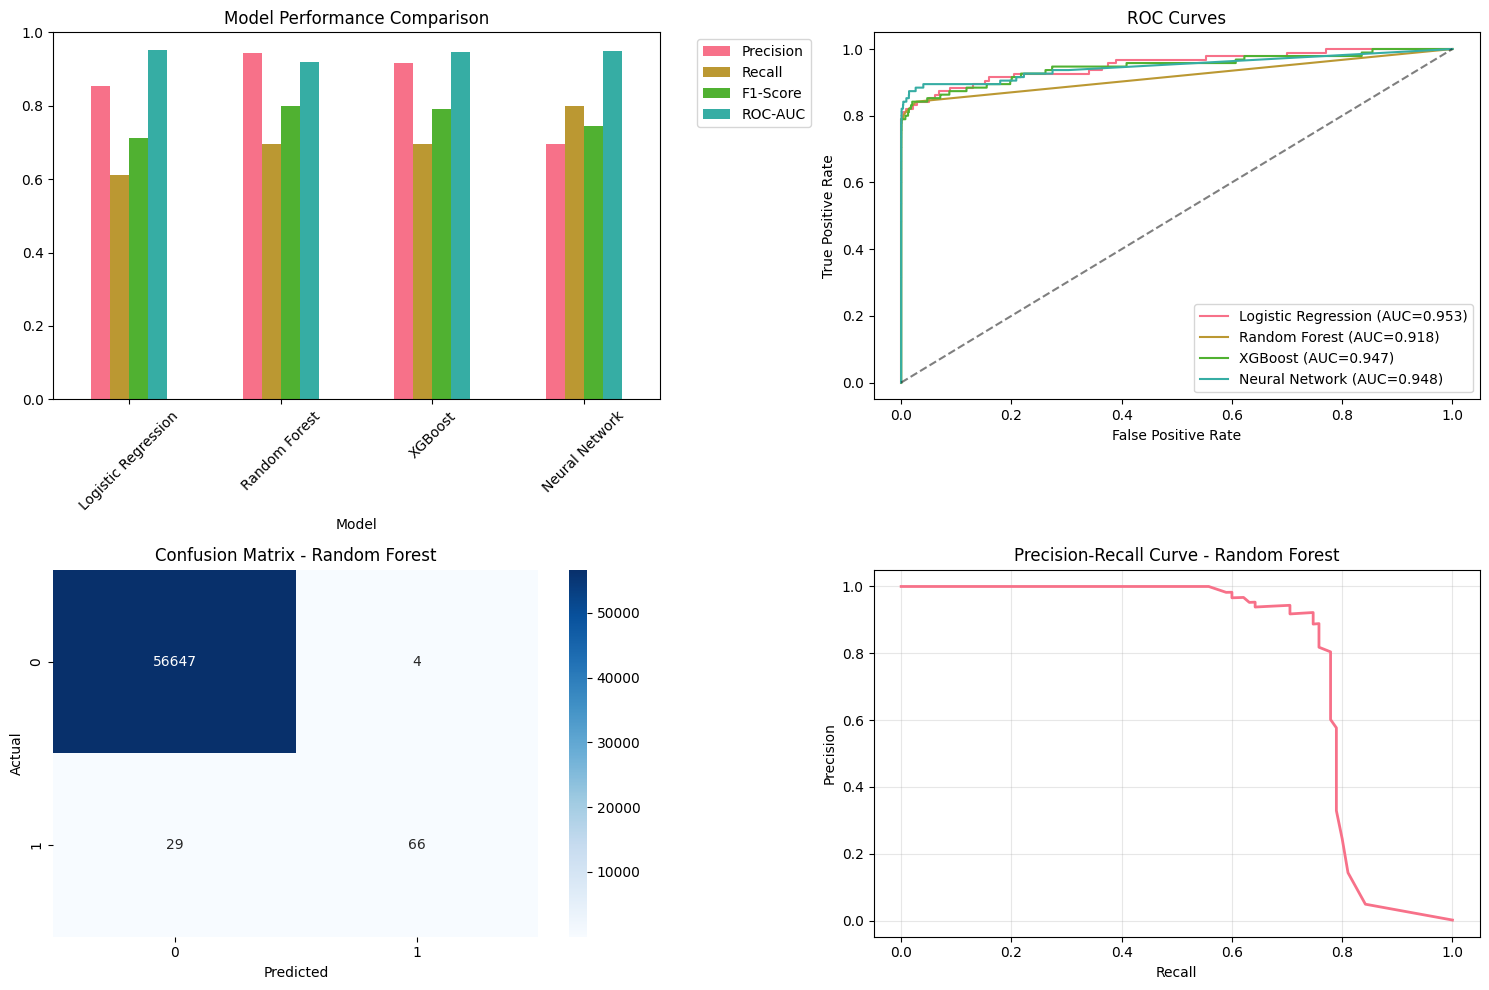


Saving best model...
✅ Model saved: best_fraud_detection_model.pkl

🎯 FINAL RESULTS:
   🏆 Best Model: Random Forest
   📊 F1-Score: 0.8000
   📈 ROC-AUC: 0.9182
   🎯 Detection Rate: 69.5%
   ⚠️ False Alarm Rate: 0.05%

✅ PIPELINE COMPLETED!
📁 Processed CSV files saved in 'processed_data/' folder


In [14]:
# Essential visualization and model saving
best_model = tuned_models[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Performance comparison
results_df.set_index('Model')[['Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(kind='bar', ax=axes[0,0], rot=45)
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].legend(bbox_to_anchor=(1.05, 1))

# 2. ROC curves
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    axes[0,1].plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves')
axes[0,1].legend()

# 3. Confusion matrix
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 4. Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, results[best_model_name]['y_pred_proba'])
axes[1,1].plot(recall_vals, precision_vals, linewidth=2)
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title(f'Precision-Recall Curve - {best_model_name}')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save best model (keeping scaler as joblib for model deployment)
print(f"\nSaving best model...")
if best_model_name != 'Neural Network':
    joblib.dump(best_model, 'best_fraud_detection_model.pkl')
    joblib.dump(scaler, 'feature_scaler.pkl')  # Keep scaler as pkl for deployment
    print(f"✅ Model saved: best_fraud_detection_model.pkl")
else:
    best_model.save('best_fraud_detection_model.h5')
    joblib.dump(scaler, 'feature_scaler.pkl')
    print(f"✅ Model saved: best_fraud_detection_model.h5")

# Final results
detection_rate = results[best_model_name]['recall'] * 100
false_alarm_rate = (1 - precision_score(y_test, results[best_model_name]['y_pred'], pos_label=0)) * 100

print(f"\n🎯 FINAL RESULTS:")
print(f"   🏆 Best Model: {best_model_name}")
print(f"   📊 F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   📈 ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"   🎯 Detection Rate: {detection_rate:.1f}%")
print(f"   ⚠️ False Alarm Rate: {false_alarm_rate:.2f}%")
print(f"\n✅ PIPELINE COMPLETED!")
print(f"📁 Processed CSV files saved in 'processed_data/' folder")
